#### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

Cloning into 'doduo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 37 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), 42.06 KiB | 1.36 MiB/s, done.


In [ ]:
%cd doduo

/content/doduo


In [ ]:
!bash download.sh

--2023-05-29 09:29:08--  https://doduo-data.s3-us-west-2.amazonaws.com/data.tar.gz
Resolving doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)... 3.5.83.139, 52.92.211.130, 52.218.182.153, ...
Connecting to doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)|3.5.83.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106987437 (102M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 102.03M  25.6MB/s    in 6.9s    

2023-05-29 09:29:15 (14.8 MB/s) - ‘data.tar.gz’ saved [106987437/106987437]

./._data
./data/
./data/._msato_cv_4.csv
./data/msato_cv_4.csv
./data/._msato_cv_2.csv
./data/msato_cv_2.csv
./data/._msato_cv_3.csv
./data/msato_cv_3.csv
./data/._msato_cv_1.csv
./data/msato_cv_1.csv
./data/._msato_cv_0.csv
./data/msato_cv_0.csv
./data/._table_col_type_serialized.pkl
./data/table_col_type_serialized.pkl
./data/._sato_cv_3.csv
./data/sato_cv_3.csv
./data/._sato

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


#### Import Modules

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (

    accuracy_score,
    f1_score,
    classification_report
)

from transformers import (
    T5Tokenizer,
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup ,
    get_constant_schedule_with_warmup
)

from transformers.models.auto.processing_auto import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from pandas.errors import SettingWithCopyWarning
import warnings
import random

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


import locale
locale.getpreferredencoding = lambda: "UTF-8"

##### Preprocessing Functions

In [ ]:
def create_map_dict_for_labels(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}

  return my_dict , my_inv_dict

def calculate_tablewise_relationships(temp_df):
  '''
  With respect to a dataframe, concatenate tablewise
  data values and labels values
  '''

  data_list_concat = []
  labels_list_concat = []
  final_data_list = []
  final_label_list = []

  for (index, group_df) in temp_df.groupby('table_id'):
    temp_data_list_concat = []
    temp_labels_list_concat = []
    total_rows , total_cols = group_df.shape
    data_list = group_df.data.values.tolist()
    labels_list = group_df.new_labels.values.tolist()
    for i,d in enumerate(data_list):
      if i == total_rows -1:
        break
      else:
        temp_data_list_concat.append(' '.join(data_list[i:i+2]))
    for i,d in enumerate(labels_list):
      if i==0:
        temp_labels_list_concat.append(labels_list[1] + ' </s>')
      elif i == total_rows -1:
        break
      else:
        temp_labels_list_concat.append(labels_list[i+1]+ ' </s>')

    data_list_concat.append(' </s> '.join(temp_data_list_concat)+ ' </s>')
    labels_list_concat.append(' '.join(temp_labels_list_concat))

  for t in data_list_concat:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    final_data_list.append('multilabel classification: ' + texty)

  for t in labels_list_concat:
    split_list = t.split(' ')
    final_label_list.append(mul_given_list(split_list,my_inv_dict))

  return final_data_list , final_label_list


def mul_given_list(temp,my_inv_dict):
  '''
  With respect to a give list - replace the element
  with the value of my_inv_dict
  '''
  new_list = []
  for t in temp:
    if t in my_inv_dict.keys():
      new_list.append(str(my_inv_dict.get(t)))
    else:
      new_list.append(t)
  return ' '.join(new_list)

##### Preprocessing Classes

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.SEED = 42
        self.MODEL_PATH = 't5-base'
        self.TOKENIZER = T5Tokenizer.from_pretrained('google/mt5-small')
        self.SRC_MAX_LENGTH = 250
        self.TGT_MAX_LENGTH = 50
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = False
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.OUTPUT_PATH = '/content/T5model_tablewise_relationship.pt'
        self.EPOCHS = 10

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, texts,labels):
        super(T5Dataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            self.labels[index],
            max_length=self.tgt_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }



#### Data Preprocessing

In [ ]:
config = Config()

# load the data
with open('/content/doduo/data/table_rel_extraction_serialized.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [ ]:
train_df = all_data.get('train')
val_df = all_data.get('dev')
whole_df = all_data.get('train')

In [ ]:
# create a dictionary (and inverse) with respect to labels of df
my_dict , my_inv_dict = create_map_dict_for_labels(whole_df)

for key,value in my_dict.items():
  print(key , value)

0 american_football.football_player.games-american_football.player_game_statistics.team
1 american_football.football_player.position_s
2 aviation.airline.hubs
3 aviation.airport.serves
4 award.award_category.category_of
5 award.award_category.nominees-award.award_nomination.award_nominee
6 award.award_category.nominees-award.award_nomination.ceremony
7 award.award_category.winners-award.award_honor.award_winner
8 award.award_category.winners-award.award_honor.ceremony
9 award.award_ceremony.awards_presented-award.award_honor.award_winner
10 award.award_ceremony.awards_presented-award.award_honor.honored_for
11 award.award_ceremony.nominees-award.award_nomination.award_nominee
12 award.award_ceremony.nominees-award.award_nomination.nominated_for
13 award.award_nominated_work.award_nominations-award.award_nomination.award_nominee
14 award.award_nominated_work.award_nominations-award.award_nomination.ceremony
15 award.award_nominee.award_nominations-award.award_nomination.nominated_for
16

In [ ]:
# create new column of new_labels which is based to stringfy the values of the column labels
train_df['new_labels'] = train_df['labels'].apply(lambda x:  ' , '.join(x))
val_df['new_labels'] = val_df['labels'].apply(lambda x:  ' , '.join(x))

train_data_list , train_label_list = calculate_tablewise_relationships(train_df)
val_data_list , val_label_list = calculate_tablewise_relationships(val_df)


print('Length of training-data list : {}'.format(len(train_data_list)))
print('Length of training-label list : {}'.format(len(train_label_list)))

print('Length of validation-data list : {}'.format(len(val_data_list)))
print('Length of validation-label list : {}'.format(len(val_label_list)))

Length of training-data list : 52943
Length of training-label list : 52943
Length of validation-data list : 1560
Length of validation-label list : 1560


In [ ]:
# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data = T5Dataset(texts=train_data_list, labels=train_label_list)
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)

val_data = T5Dataset(texts=val_data_list, labels=val_label_list)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

##### Example of the Dataset

In [ ]:
train_df[train_df.table_id.str.contains('1000530-1')]

,table_id,column_id,labels,data,label_ids,new_labels
36271,1000530-1,0,[],Askeran Hadrut Martakert Martuni Qashatagh Sha...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
36272,1000530-1,1,[location.location.contains],Askeran Hadrut Martakert Martuni Berdzor Kalba...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",location.location.contains


In [ ]:
print(train_data_list[1])
print(train_label_list[1])
print()
print(my_dict.get(66))

multilabel classification: askeran hadrut martakert martuni qashatagh shahumian shushi stepanakert  ( capital )  askeran hadrut martakert martuni berdzor kalbajar  ( formerly shahumian  )  shushi stepanakert </s>
66 </s>

location.location.contains


In [ ]:
train_df[train_df.table_id.str.contains('10015132-13')]

,table_id,column_id,labels,data,label_ids,new_labels
36292,10015132-13,0,[],Mamadou N'Diaye Radoslav Nesterovič Steve Novak,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
36293,10015132-13,1,[people.person.nationality],Senegal Slovenia United States,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",people.person.nationality
36294,10015132-13,2,[sports.pro_athlete.teams-sports.sports_team_r...,Center Center Forward,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports.pro_athlete.teams-sports.sports_team_ro...


In [ ]:
print(train_data_list[11])
print(train_label_list[11])
print()
print(my_dict.get(87))
print(my_dict.get(95))

multilabel classification: mamadou n'diaye radoslav nesterovič steve novak senegal slovenia united states </s> senegal slovenia united states center center forward </s>
87 </s> 95 </s>

people.person.nationality
sports.pro_athlete.teams-sports.sports_team_roster.position


#### Data Visualizations

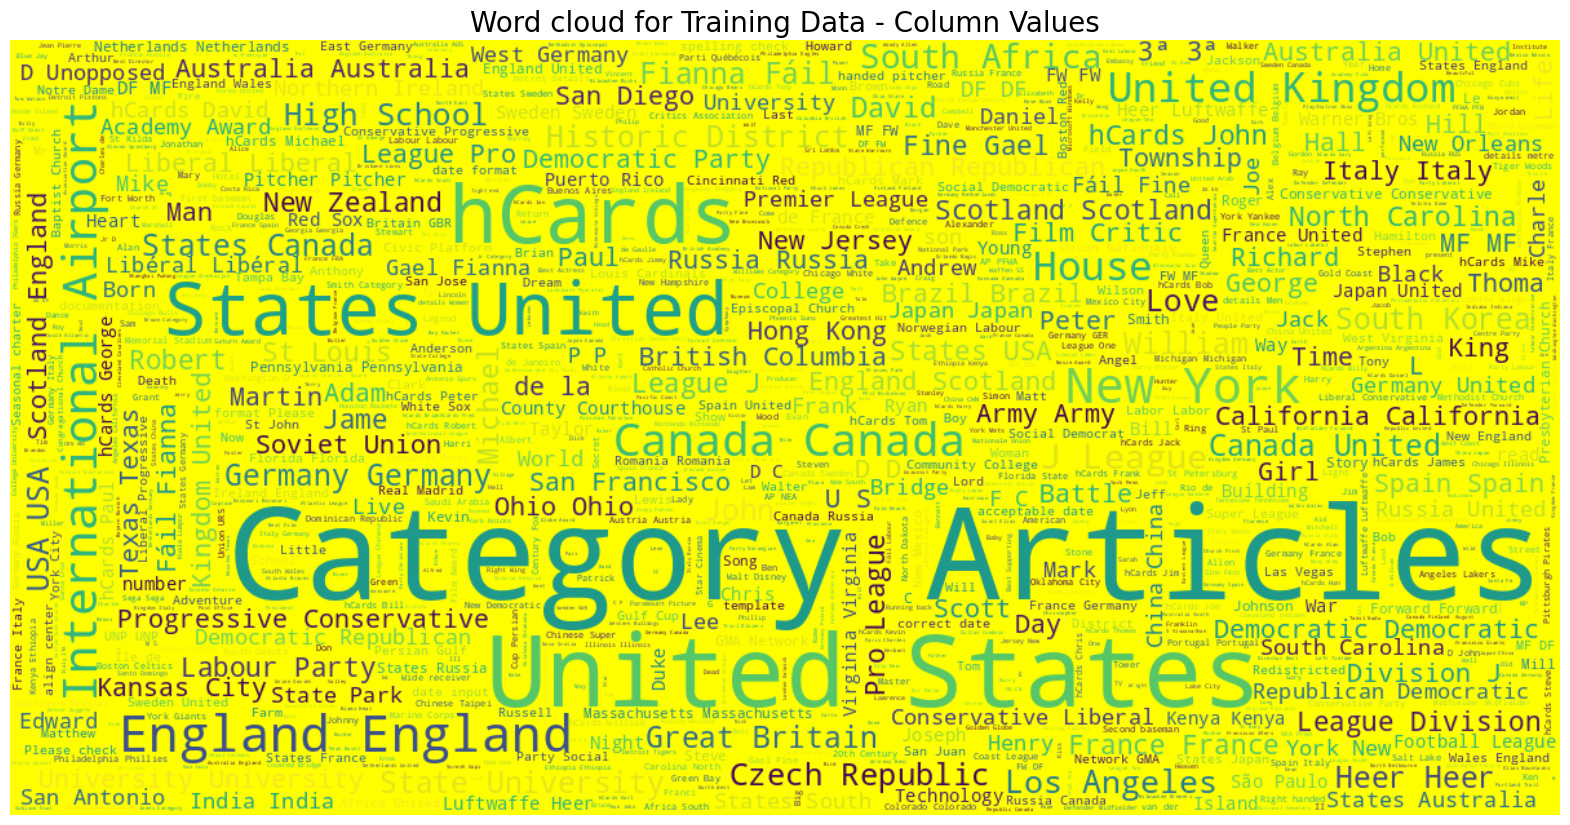

In [ ]:
# WordCloud

train_data_ex = train_df['data']
train_data_ex_string = ' '.join(train_data_ex)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="yellow",stopwords=STOPWORDS).generate(train_data_ex_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Training Data - Column Values',fontsize = 20)
plt.show()


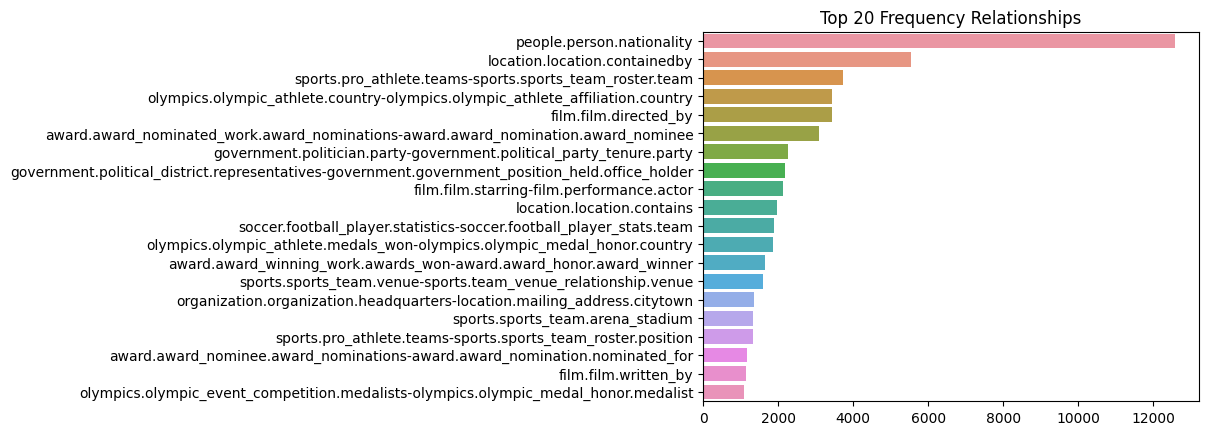

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()
sns.barplot(y=train_df_value_counts.head(20).index, x=train_df_value_counts.head(20).values)
plt.title('Top 20 Frequency Relationships')
plt.show()

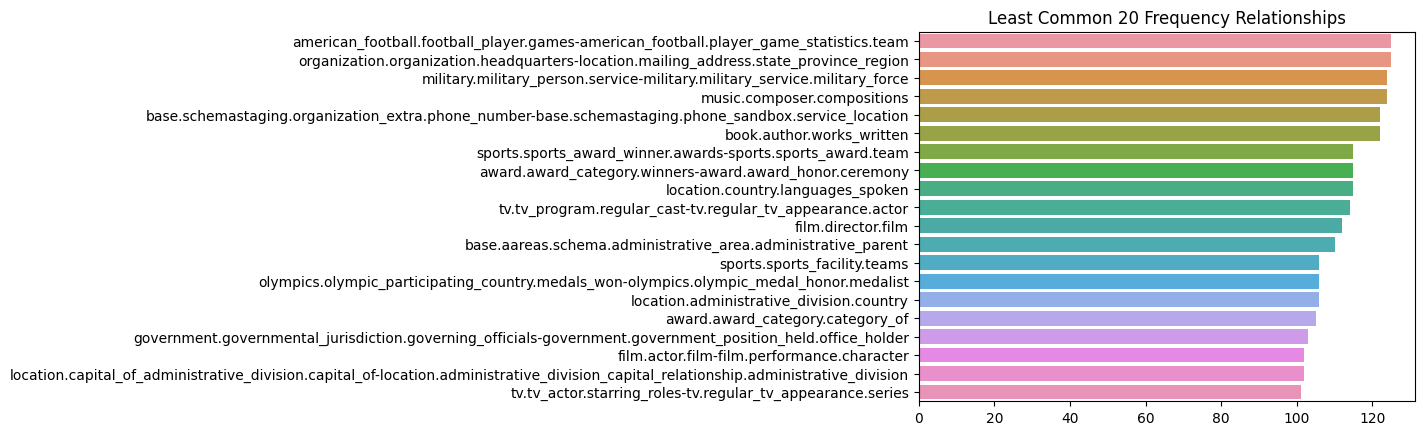

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()
sns.barplot(y=train_df_value_counts.tail(20).index, x=train_df_value_counts.tail(20).values)
plt.title('Least Common 20 Frequency Relationships')
plt.show()

##### Tokenizer Length Distribution

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


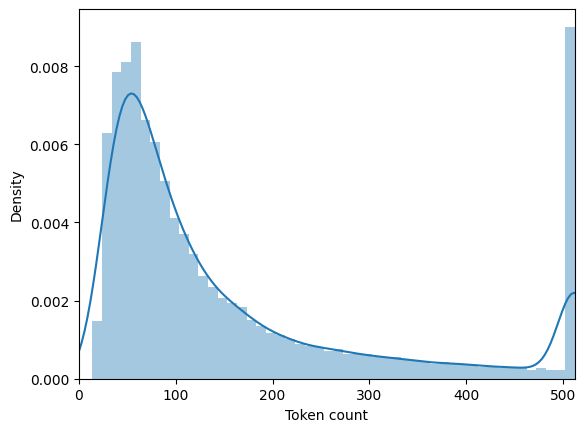

In [ ]:
tmp_tokenizer = config.TOKENIZER

token_lens = []

for txt in train_data_list:
  tokens = tmp_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

#### T5 Training

##### Training Classes

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()
        self.t5_model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')

    def forward(
        self,
        input_ids,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

##### Training Functions

In [ ]:
def convert_to_ohe(temp_list):
  '''
  Convert predicted list , with target values, to
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 121
  '''
  global_list = []
  for temp_batch in temp_list:
    base = 121*[0]
    temp_list_decomp= temp_batch.split(' ')
    for l in temp_list_decomp:
      if l is None or l.strip() =='':
        continue
      else:
        temp = l.strip()
      if int(temp) in my_dict.keys():
        base[ int(temp) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)


In [ ]:
def val(model, val_dataloader, criterion):
    '''
    The function that is utilized to the validation phase
    with th respective dataloader
    '''

    val_loss = 0
    true, pred = [], []

    # set model.eval() every time during evaluation
    model.eval()

    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id,skip_special_tokens=True).replace(",", "")
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")
                pred.append(pred_decoded)

    true_ohe = convert_to_ohe(true)
    pred_ohe = convert_to_ohe(pred)

    # for Debugging
    # print('******'*8)
    # print(set(pred))
    # print('******'*8)


    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score , avg_val_loss


def train(
    model,
    train_dataloader,
    criterion,
    optimizer,
    scheduler,
    epoch
    ):
    '''
    The function that is utilized to the training phase
    with th respective dataloader
    '''

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()

        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids,
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        # update scheduler
        scheduler.step()


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    return model , avg_train_loss

In [ ]:
# define the model
# and move from CPU to GPU

device = config.DEVICE
model = T5Model()
model.to(device);

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
# define the parameters to be optmized
torch.manual_seed(config.SEED)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.LR)


if config.FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

scheduler = get_constant_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0)

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

# set the max val F1-score
max_val_micro_f1_score = float('-inf')

# run across the Epochs
for epoch in range(config.EPOCHS):
    model , avg_train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, epoch)
    val_micro_f1_score , avg_val_loss = val(model, val_dataloader, criterion)
    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)
    if config.SAVE_BEST_ONLY:
        # save and overwrite only the best model
        # with the highest F1 score in validation
        if val_micro_f1_score > max_val_micro_f1_score:
            max_val_micro_f1_score = val_micro_f1_score
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(),config.OUTPUT_PATH)
            print(f'Best F1-score in Validation : {max_val_micro_f1_score}')


Epoch 0:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 7.505301480604537
Val loss: 2.473923570039321
Val accuracy: 0.0673076923076923
Val micro f1 score: 0.07334273624823695
Best F1-score in Validation : 0.07334273624823695


Epoch 1:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 2.755375677237305
Val loss: 2.0869956685572255
Val accuracy: 0.0673076923076923
Val micro f1 score: 0.07334273624823695


Epoch 2:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 2.20732249724393
Val loss: 1.8595518761751604
Val accuracy: 0.0673076923076923
Val micro f1 score: 0.07334273624823695


Epoch 3:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 1.9437802420638053
Val loss: 1.6844857809494953
Val accuracy: 0.07115384615384615
Val micro f1 score: 0.08368594264221908
Best F1-score in Validation : 0.08368594264221908


Epoch 4:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 1.6840389442969823
Val loss: 1.3952585702039757
Val accuracy: 0.16346153846153846
Val micro f1 score: 0.24408092983211366
Best F1-score in Validation : 0.24408092983211366


Epoch 5:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 1.3496217189481086
Val loss: 1.0641646981239319
Val accuracy: 0.2980769230769231
Val micro f1 score: 0.4215156968606279
Best F1-score in Validation : 0.4215156968606279


Epoch 6:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 1.103291377215794
Val loss: 0.8745643842433181
Val accuracy: 0.3698717948717949
Val micro f1 score: 0.4894822006472492
Best F1-score in Validation : 0.4894822006472492


Epoch 7:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 0.9409839650207945
Val loss: 0.7346494748276107
Val accuracy: 0.4237179487179487
Val micro f1 score: 0.5512041884816753
Best F1-score in Validation : 0.5512041884816753


Epoch 8:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 0.8269377887214093
Val loss: 0.6425449926862303
Val accuracy: 0.4493589743589744
Val micro f1 score: 0.5990942419667888
Best F1-score in Validation : 0.5990942419667888


Epoch 9:   0%|          | 0/3309 [00:00<?, ?it/s]

Training loss: 0.739814948045583
Val loss: 0.5809364488481411
Val accuracy: 0.48012820512820514
Val micro f1 score: 0.6292861764071598
Best F1-score in Validation : 0.6292861764071598


##### Training Graph of the model

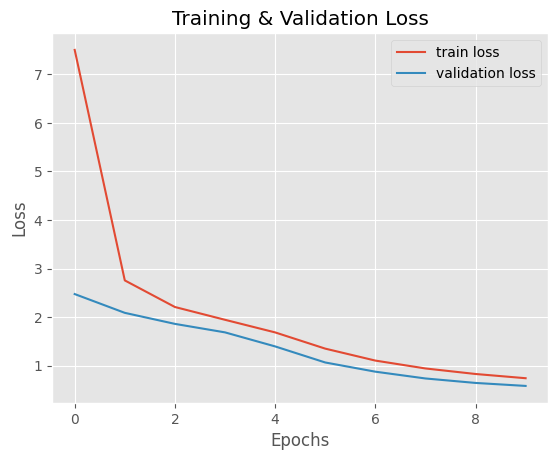

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = config.EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list, label="train loss")
plt.plot(np.arange(0, N), avg_val_loss_list, label="validation loss")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

##### Save the Model to Drive

In [ ]:
! cp -r /content/T5model_tablewise_relationship.pt /content/drive/MyDrive/'Colab Notebooks'/Databases/T5_models

#### Loading the Model & Inference Examples

In [ ]:
load_T5_model = T5Model()
load_T5_model.to(config.DEVICE);
load_T5_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Databases/T5_models/T5model_tablewise_relationship.pt'))

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


<All keys matched successfully>

In [ ]:
inference_val_dataloader = DataLoader(val_data, batch_size=1)

#### Inference Functions

In [ ]:
def convert_to_true_labels(inv_dict_labels):
  '''
  Convert from inv-dict labels to
  true labels
  '''
  gen = []
  inv_dict_labels_list = inv_dict_labels.split(' ')
  for l in inv_dict_labels_list:
    if l is not None or l != '':
      if int(l) in my_dict.keys():
        gen.append(my_dict.get(int(l)))
  return ' & '.join(gen)

def inference_single_example(temp_model,temp_batch):
  '''
  With respect to a model and batch we make inference for a single example
  '''

  b_src_input_ids = temp_batch['src_input_ids'].to(config.DEVICE)
  b_src_attention_mask = temp_batch['src_attention_mask'].to(config.DEVICE)
  pred_ids = temp_model.t5_model.generate(
                input_ids=b_src_input_ids,
                attention_mask=b_src_attention_mask
            )

  pred_ids = pred_ids.cpu().numpy()
  for pred_id in pred_ids:
      pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")

  return pred_decoded

#### Inference for certain examples of the Validation Dataloader

In [ ]:
# Generate 2 random int for examples
random_list = random.sample(range(1, 100), 2)
print('Generate random indexes {} '.format(random_list))
print()

counter =0
for index, batch in enumerate(inference_val_dataloader):
  if index in random_list:
    print('Example {}'.format(counter))
    print('Data : {}'.format(config.TOKENIZER.decode(batch.get('src_input_ids')[0],skip_special_tokens=True)))
    inv_dict_labels = config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")
    print('True Inv-Dict Labels : {}'.format(config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")))
    print('True Labels : {}'.format(convert_to_true_labels(inv_dict_labels)))

    inference_ex_labels = inference_single_example(temp_model=load_T5_model,temp_batch=batch)
    print('Predicted Inv-Dict Labels : {}'.format(inference_ex_labels))
    print('Predicted Labels : {}'.format(convert_to_true_labels(inference_ex_labels)))

    print()
    counter = counter +1

Generate random indexes [74, 49] 

Example 0
Data : multilabel classification: atlanta chiefs baltimore bays chicago spurs los angeles toros new york generals oakland clippers philadelphia spartans pittsburgh phantoms st. louis stars toronto falcons atlanta stadium ( 50, 893 ) memorial stadium ( 52, 185 ) soldier field ( 100, 000 ) los angeles memorial coliseum ( 93, 000 ) yankee stadium ( 67, 000 ) oakland-alameda county coliseum ( 53, 000 ) temple university stadium ( 20, 000 ) forbes field ( 35, 714 ) busch memorial stadium ( 50, 000 ) varsity stadium ( 25, 000 )
True Inv-Dict Labels : 111 105
True Labels : sports.sports_team.venue-sports.team_venue_relationship.venue & sports.sports_team.arena_stadium
Predicted Inv-Dict Labels : 111 105
Predicted Labels : sports.sports_team.venue-sports.team_venue_relationship.venue & sports.sports_team.arena_stadium

Example 1
Data : multilabel classification: lee trevino dave stockton raymond floyd jay sigel dave eichelberger united states united